## Let's run intron clustering to annotate alternative splicing events given observed junctions in our cells 

In [1]:
# Load LeafletSC 
import LeafletSC
import os
import pandas as pd 

# Define path that contains some junction files (only 2 files are used for this example, corresponding to 2 individual cells)
juncs_path = "/gpfs/commons/home/kisaev/LeafletSC/data/raw/junctions/"
print("The junctions are loaded from the following path: " + juncs_path) 

# print the files in the path 
print("The files in the path are: " + str(os.listdir(juncs_path)))

# define path for saving the output data 
output_path = "/gpfs/commons/home/kisaev/LeafletSC/data/processed/"

The junctions are loaded from the following path: /gpfs/commons/home/kisaev/LeafletSC/data/raw/junctions/
The files in the path are: ['B107926_O8_Blue_Blood_S250.homo.gencode.v30.ERCC.chrM.juncswbarcodes', 'B107925_B5_S284.homo.gencode.v30.ERCC.chrM.juncswbarcodes']


### Let's first define some parameters for the analysis

In [2]:
from LeafletSC.clustering.find_intron_clusters import main as find_intron_clusters
from LeafletSC.clustering.prepare_model_input import main as prep_model_input

# junc_files defines a path for where junction files can be found, in this case, the path is defined above
junc_files = juncs_path

# we provide a gtf file for the human genome as well to make better sense of the junctions that are detected in cells
# please replace with the path to the gtf file on your system
gtf_file="/gpfs/commons/groups/knowles_lab/Karin/genome_files/gencode.v43.basic.annotation.gtf" 

# define additional parameters 
sequencing_type = "single_cell"

# ensure output files are to be saved in output_path 
output_file = output_path + "test_intron_clusters"
junc_bed_file= output_path + "test_juncs.bed" # you can load this file into IGV to visualize the junction coordinates 
min_intron_length = 50
max_intron_length = 500000
threshold_inc = 0.05 
min_junc_reads = 2
min_num_cells_wjunc = 2
keep_singletons = False # ignore junctions that do not share splice sites with any other junction (likely const)
junc_suffix = "*.juncswbarcodes" # depends on how you ran regtools 

### Run intron clustering 

In [3]:
all_juncs_df = find_intron_clusters(junc_files=junc_files, gtf_file=gtf_file, output_file=output_file, 
                       sequencing_type=sequencing_type, junc_bed_file=junc_bed_file, 
                       threshold_inc=threshold_inc, min_intron = min_intron_length,
                       max_intron=max_intron_length, min_junc_reads=min_junc_reads,
                       singleton=keep_singletons,
                       junc_suffix=junc_suffix, min_num_cells_wjunc=min_num_cells_wjunc,
                       run_notebook = True)

Loading files obtained from single_cell sequencing
Reading in junction files from /gpfs/commons/home/kisaev/LeafletSC/data/raw/junctions
The number of junction files to be processed is 2


100%|██████████| 2/2 [00:00<00:00, 11.13it/s]

The gtf file you provided is /gpfs/commons/groups/knowles_lab/Karin/genome_files/gencode.v43.basic.annotation.gtf
Reading the gtf may take a while depending on the size of your gtf file



INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'tag', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'havana_transcript', 'exon_number', 'exon_id', 'hgnc_id', 'havana_gene', 'ont', 'protein_id', 'ccdsid', 'artif_dupl']


Reading gtf file took 122.01 seconds
+++++++++++++++++++++++++++++++++++++++++++++++++++++++
The number of unique exons is 411865
The number of unique transcript ids is 115526
The number of unique gene ids is 62668
+++++++++++++++++++++++++++++++++++++++++++++++++++++++
Done extracting exons from gtf file
Cleaning up 'chrom' column
Making gr object from all junctions across all cell types
The number of junctions prior to assessing distance to exons is 12876
Annotating junctions with known exons based on input gtf file
The number of junctions after assessing distance to exons is 11689
Clustering intron splicing events by gene_id
The number of clusters after clustering by gene_id is 11189
The number of junctions after removing singletons is 11688
The number of clusters after removing singletons is 11188
The number of clusters after filtering for shared splice sites is 214
The number of junctions after filtering for shared splice sites is 703
Refining intron clusters to account for juncti

In [4]:
# visualize junctions in an intron cluster 
list(all_juncs_df)

['junction_id',
 'counts_total',
 'chrom',
 'chromStart',
 'chromEnd',
 'name',
 'score',
 'strand',
 'thickStart',
 'thickEnd',
 'itemRgb',
 'blockCount',
 'blockSizes',
 'blockStarts',
 'num_cells_wjunc',
 'cell_readcounts',
 'file_name',
 'cell_type',
 'block_add_start',
 'block_subtract_end',
 'intron_length',
 'total_5ss_counts',
 'total_3ss_counts',
 '5SS_usage',
 '3SS_usage',
 'Cluster',
 'gene_id',
 'Count']

In [96]:
import matplotlib.pyplot as plt
import numpy as np

def basepair_to_kilobase(bp):
    return bp / 1000  # Convert base pairs to kilobases

def visualize_junctions(dat, junc_id):

    # Filter data for the specific junction ID
    dat = dat[dat.Cluster == dat[dat.junction_id == junc_id].Cluster.values[0]]

    # Get junctions
    juncs = dat[["chrom", "chromStart", "chromEnd", "strand", "intron_length", "counts_total", "thickStart", "thickEnd"]]
    juncs = juncs.drop_duplicates()
    juncs["junc_usage_ratio"] = dat["counts_total"] / dat["counts_total"].sum()

    # Sort junctions based on strand
    if juncs.strand.values[0] == "+":
        juncs = juncs.sort_values("chromStart")
    else:
        juncs = juncs.sort_values("chromEnd", ascending=False)

    # Convert genomic coordinates to kilobases
    juncs["chromStart_kb"] = basepair_to_kilobase(juncs["chromStart"])
    juncs["chromEnd_kb"] = basepair_to_kilobase(juncs["chromEnd"])
    print(juncs)
    # Create colormap
    cmap = plt.get_cmap('plasma')

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, len(juncs) * 0.5))

    # Plot junctions as lines with varying colors based on usage ratio
    for i, (_, junc) in enumerate(juncs.iterrows()):
        color = cmap(junc["junc_usage_ratio"])
        ax.plot([junc["chromStart_kb"], junc["chromEnd_kb"]], [i, i], color=color)
        ax.text(junc["chromEnd_kb"], i, f'{junc["junc_usage_ratio"]:.2f}', verticalalignment='center', fontsize=8, color=color)

    # Set labels and title 
    ax.set_xlabel("Genomic Position on chr" + juncs.chrom.values[0] + " (" + juncs.strand.values[0] + ") [Kilobases]")
    ax.set_yticks(list(range(len(juncs))))
    ax.set_title(f"Visualization of Junctions in Cluster {dat.Cluster.values[0]} in the Gene {dat.gene_id.values[0]}")
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}'.format(x)))  # Disable scientific notation
    print("The junction of interest is " + junc_id)
    plt.show()


  chrom  chromStart  chromEnd strand  intron_length  counts_total  thickStart  \
2    10    68755536  68756272      +            736            63    68755442   
3    10    68755536  68757293      +           1757             7    68755470   
4    10    68756483  68757293      +            810            38    68756384   

   thickEnd  junc_usage_ratio  chromStart_kb  chromEnd_kb  
2  68756369          0.583333      68755.536    68756.272  
3  68757377          0.064815      68755.536    68757.293  
4  68757377          0.351852      68756.483    68757.293  
The junction of interest is 10_68755536_68756272


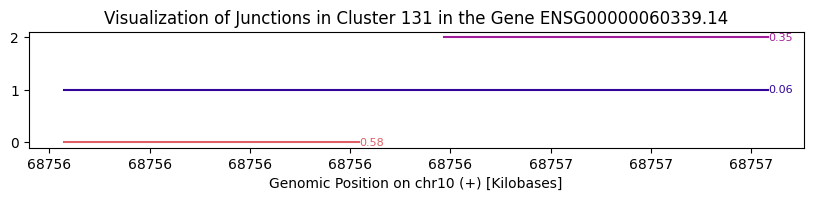

In [97]:
#from LeafletSC.clustering.find_intron_clusters import visualize_junctions
junc_id = all_juncs_df.junction_id.sample(1).values[0]
j = junc_id
visualize_junctions(all_juncs_df, j)

In [95]:
all_juncs_df

,junction_id,counts_total,chrom,chromStart,chromEnd,name,score,strand,thickStart,thickEnd,...,block_add_start,block_subtract_end,intron_length,total_5ss_counts,total_3ss_counts,5SS_usage,3SS_usage,Cluster,gene_id,Count
0,10_118326243_118335113,6,10,118326243,118335113,JUNC00005275,6,-,118326153,118335119,...,90,6,8870,22,6,0.272727,1.000000,142,ENSG00000165669.14,2
1,10_118326243_118335553,16,10,118326243,118335553,JUNC00005276,16,-,118326164,118335637,...,79,84,9310,22,16,0.727273,1.000000,142,ENSG00000165669.14,2
2,10_68755536_68756272,63,10,68755536,68756272,JUNC00005015,63,+,68755442,68756369,...,94,97,736,70,63,0.900000,1.000000,131,ENSG00000060339.14,3
3,10_68755536_68757293,7,10,68755536,68757293,JUNC00005016,7,+,68755470,68757377,...,66,84,1757,70,45,0.100000,0.155556,131,ENSG00000060339.14,3
4,10_68756483_68757293,38,10,68756483,68757293,JUNC00005018,38,+,68756384,68757377,...,99,84,810,38,45,1.000000,0.844444,131,ENSG00000060339.14,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,X_48575283_48575560,207,X,48575283,48575560,JUNC00010833,32,+,48575185,48575651,...,98,91,277,222,207,0.932432,1.000000,314,ENSG00000102317.18,3
425,X_48575283_48575560,207,X,48575283,48575560,JUNC00009649,175,+,48575184,48575658,...,99,98,277,222,207,0.932432,1.000000,314,ENSG00000102317.18,3
426,X_48575283_48576313,15,X,48575283,48576313,JUNC00009648,15,+,48575184,48576412,...,99,99,1030,222,205,0.067568,0.073171,314,ENSG00000102317.18,3
427,X_48575667_48576313,190,X,48575667,48576313,JUNC00010835,27,+,48575568,48576412,...,99,99,646,190,205,1.000000,0.926829,314,ENSG00000102317.18,3


### Now let's convert the intron clusters to a format that can be used by LeafletSC

In [ ]:
intron_clusters = "/gpfs/commons/home/kisaev/LeafletSC/data/processed/test_intron_clusters_50_500000_2_20240309_single_cell.gz" # path to the intron clusters file
output_file = output_path + "test_model_input" # name of the output file
has_genes = "yes" # since we used a gtf file to obtain the intron clusters, we can set this to yes
chunk_size = 5000 # number of junctions to process at a time from the intron clusters files
metadata = None # can replace with path, if metadata is available for cells (cell type, origin, library ID...)

In [ ]:
prep_model_input(intron_clusters, output_file, has_genes, chunk_size, metadata)

### Take a quick look at the input file that will go into the model to get familiarized with all the columns

In [ ]:
model_input_data = "/gpfs/commons/home/kisaev/LeafletSC/data/processed/test_model_input.h5"
summarized_data = pd.read_hdf(model_input_data, 'df')
print(summarized_data.head())

#### Note that fow now, the values in cell_type default to the cell's path, in the future it will be possible to specify the cell type in the metadata file

In [ ]:
summarized_data.cell_type.unique()

In [ ]:
# let's see all the columns in the summarized data
print(summarized_data.columns)

#### We can quickly visualize the overall junction usage ratio distribution across all cells

In [ ]:
print(summarized_data.junc_ratio.hist())

### Now we have everything need to run the Leaflet mixture model! Please refer to the next notebook for the next steps.